In [77]:
import requests
import random
import pandas as pd
from bs4 import BeautifulSoup
from tqdm.auto import tqdm, trange
from heapdict import heapdict
import razdel
import json
import re

https://rus4all.ru/myv

In [86]:
def text_with_newlines(elem):
    text = ''
    for e in elem.descendants:
        if isinstance(e, str):
            text += e.strip()
        elif e.name == 'br':
            text += '\n'
        elif e.name == 'p':
            text += '\n\n'
    text = re.sub('\n\n+', '\n\n', text)
    text = '\n'.join([line for line in text.split('\n') if not line or re.match('.*[а-яa-z]', line.lower())]).strip()
    text = re.sub('\n\n+', '\n\n', text)
    return text

In [91]:
soup = BeautifulSoup(requests.get('https://rus4all.ru/myv/20190523/9392/Bez-slov.html').text)

In [92]:
print(text_with_newlines(soup.find('div', {'id':"tab-source"})))

Валтомо

Мон тонь вешитинь верде, тосто,
Ков а весень пачколить мелест.
Мон тонь артытинь эсень коцтос —
Лембе валдокс чоподанть келес.

Мон совавтытинь валрисьмезэнь —
Эрьва гайтьсэнть эрязо леметь.
А тон кортыть видьстэ сельмезэнь:
Зярдояк монень эзить кеме.

Кортыть тон: сталмовтомот валтнэ —
Видечист онкстамс кона ёндо? —
Седе паро — мезтькак а алтнемс,
Сестэ а кинь ули чумондомс.

Кода мерят, топавтса мелеть, —
Кадык чемень валсынзе онкстнэнь:
Панжсынь валтомо мон икелеть
Модамасторонь ниле ёнкстнэнь.


In [93]:
print(text_with_newlines(soup.find('div', {'id':"tab-literary"})))

Без слов

Тебя я выпросила свыше,
Куда не все мольбы доходят.
Ты на холсте моём был вышит —
По темноте теплом восхода.

И лишь тобой дышали строки,
Хранили звуки твоё имя.
А ты искал во мне пороки,
Считая все слова пустыми.

А ты твердил: слова что ветер,
Правдивы ли, измерить нечем;
Чтобы не быть за них в ответе,
Не обещай — так будет легче.

Исполню все твои заветы,
Ослушаться тебя не смея.
Четыре стороны у света —
Без слов открою их тебе я.


In [90]:
pairs = []

for page in range(1, 6):
    soup = BeautifulSoup(requests.get(f'https://rus4all.ru/ajax/rubric/default_abc.html?list_sid=myv&page={page}').text)
    for h in soup.findAll('h3'):
        url = 'https://rus4all.ru' + h.find('a')['href']
        print(url)
        soup = BeautifulSoup(requests.get(url).text)
        if soup.find('div', {'id':"tab-source"}) and soup.find('div', {'id':"tab-literary"}):
            pairs.append({
                'url': url, 
                'myv': text_with_newlines(soup.find('div', {'id':"tab-source"})),
                'ru': text_with_newlines(soup.find('div', {'id':"tab-literary"}))
            })
            print('bi')
        else:
            print('mono')

https://rus4all.ru/myv/20191122/21056/Beda.html
bi
https://rus4all.ru/myv/20190523/9392/Bez-slov.html
bi
https://rus4all.ru/myv/20191122/20996/Bez-tebya-ya.html
bi
https://rus4all.ru/myv/20190523/9511/Vremya.html
bi
https://rus4all.ru/myv/20190523/9493/Vspominayu.html
bi
https://rus4all.ru/myv/20191122/21083/V-shkolu.html
mono
https://rus4all.ru/myv/20191122/21004/Golubykh-tumanov-livni.html
bi
https://rus4all.ru/myv/20190523/9424/Dni-begut-kak-v-chistom-pole-koni.html
bi
https://rus4all.ru/myv/20191122/21107/Zhil-byl-Rodnik.html
mono
https://rus4all.ru/myv/20200310/25702/Zatoptannyy-venok.html
bi
https://rus4all.ru/myv/20191122/21067/Zvzdochka.html
mono
https://rus4all.ru/myv/20191122/20968/Kak-s-gusinykh-krylev-perya.html
bi
https://rus4all.ru/myv/20191122/21091/Karta-lesa.html
mono
https://rus4all.ru/myv/20191122/21123/Kolyuchka.html
mono
https://rus4all.ru/myv/20190523/9485/Leto-put-pochti-preodolelo.html
bi
https://rus4all.ru/myv/20201008/29418/Lyubimka.html
bi
https://rus4all.ru/

In [94]:
print(len(pairs))

30


In [95]:
with open('other_sources/rus4all_sections_unaligned.json', 'w') as f:
    json.dump(pairs, f)

# trying to align

In [1]:
import json
with open('other_sources/rus4all_sections_unaligned.json', 'r') as f:
    pairs = json.load(f)

In [2]:
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
from razdel import sentenize, tokenize
import json 
import re
import random
from tqdm.auto import tqdm, trange
import razdel

In [3]:
import torch
from transformers import AutoTokenizer, AutoModel
mname = 'labse_erzya_v0'
tokenizer = AutoTokenizer.from_pretrained(mname)
model = AutoModel.from_pretrained(mname)

Some weights of the model checkpoint at labse_erzya_v0 were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [4]:
model.cuda();

In [5]:
def embed(text):
    encoded_input = tokenizer(text, padding=True, truncation=True, max_length=128, return_tensors='pt')
    with torch.inference_mode():
        model_output = model(**encoded_input.to(model.device))
    embeddings = model_output.pooler_output
    embeddings = torch.nn.functional.normalize(embeddings)
    return embeddings[0].cpu().numpy()

In [6]:
def center_norm(v):
    v = v - v.mean(0)
    return v /  (v**2).sum(1, keepdims=True) ** 0.5


def center_dot(x, y):
    m = (x.sum(0) + y.sum(0)) / (x.shape[0] + y.shape[0])
    x = x - m
    y = y - m
    x =  x /  (x**2).sum(1, keepdims=True) ** 0.5
    y =  y /  (y**2).sum(1, keepdims=True) ** 0.5
    return np.dot(x, y.T)

In [7]:
def get_top_mean_by_row(x, k=5):
    m, n = x.shape
    k = min(k, n)
    topk_indices = np.argpartition(x, -k, axis=1)[:, -k:]
    rows, _ = np.indices((m, k))
    return x[rows, topk_indices].mean(1)

In [8]:
def align3(sims):
    
    #sims = np.dot(center_norm(orig_vecs), center_norm(sum_vecs).T) ** 3
    #sims = center_dot(orig_embeds, sum_embeds) #** 3

    rewards = np.zeros_like(sims)
    choices = np.zeros_like(sims).astype(int)  # 1: choose this pair, 2: decrease i, 3: decrease j

    # алгоритм, разрешающий пропускать сколько угодно пар, лишь бы была монотонность
    for i in range(sims.shape[0]):
        for j in range(0, sims.shape[1]):
            # вариант первый: выровнять i-тое предложение с j-тым
            score_add = sims[i, j]
            if i > 0 and j > 0:  # вот как тогда выровняются предыдущие 
                score_add += rewards[i-1, j-1]
                choices[i, j] = 1
            best = score_add
            if i > 0 and rewards[i-1, j] > best:
                best = rewards[i-1, j]
                choices[i, j] = 2
            if j > 0 and rewards[i, j-1] > best:
                best = rewards[i, j-1]
                choices[i, j] = 3
            rewards[i, j] = best
    alignment = []
    i = sims.shape[0] - 1
    j = sims.shape[1] - 1
    while i > 0 and j > 0:
        if choices[i, j] == 1:
            alignment.append([i, j])
            i -= 1
            j -= 1
        elif choices[i, j] == 2:
            i -= 1
        else:
            j -= 1
    return alignment[::-1]

In [9]:
def make_sents(text):
    sents = [s.text.replace('\n', ' ').strip() for p in text.split('\n\n') for s in razdel.sentenize(p)]
    sents = [s for s in sents if s]
    return sents

In [12]:
for p in pairs:
    print(p['url'])
    sents_ru = [s.text for s in razdel.sentenize(p['ru'])]
    sents_er = [s.text for s in razdel.sentenize(p['myv'])]
    print(len(sents_ru), len(sents_er))
    # print(len(sent_tokenize(p['ru'])), len(sent_tokenize(p['myv'])))
    print(len(make_sents(p['ru'])), len(make_sents(p['myv'])))
    print(len(p['ru'].split('\n\n')), len(p['myv'].split('\n\n')))
    print(len(p['ru'].split('\n')), len(p['myv'].split('\n')))

https://rus4all.ru/myv/20191122/21056/Beda.html
4 4
5 5
3 3
11 11
https://rus4all.ru/myv/20190523/9392/Bez-slov.html
8 7
9 8
5 5
21 21
https://rus4all.ru/myv/20191122/20996/Bez-tebya-ya.html
9 11
9 11
2 2
18 19
https://rus4all.ru/myv/20190523/9511/Vremya.html
6 8
7 9
4 4
16 16
https://rus4all.ru/myv/20190523/9493/Vspominayu.html
11 9
11 9
4 4
16 16
https://rus4all.ru/myv/20191122/21004/Golubykh-tumanov-livni.html
5 6
5 6
3 3
14 14
https://rus4all.ru/myv/20190523/9424/Dni-begut-kak-v-chistom-pole-koni.html
7 8
7 8
3 3
14 14
https://rus4all.ru/myv/20200310/25702/Zatoptannyy-venok.html
290 230
301 243
107 106
213 211
https://rus4all.ru/myv/20191122/20968/Kak-s-gusinykh-krylev-perya.html
2 4
2 4
2 2
9 9
https://rus4all.ru/myv/20190523/9485/Leto-put-pochti-preodolelo.html
5 5
5 5
3 3
14 14
https://rus4all.ru/myv/20201008/29418/Lyubimka.html
27 27
30 30
14 13
27 25
https://rus4all.ru/myv/20190523/9442/Mame.html
8 9
9 10
4 4
16 16
https://rus4all.ru/myv/20200617/27752/Medvezhiy-ugol.html
496 

0 - тривиально
1 - только по абзацам,
2 - динамическое программирование по предложениям
3 - лучше по четверостишиям
4 - можно по предложениям, но надо следить, чтобы длины примерно совпадали
7 - очень плохо выравнивает, сложно
12 - очень сложно и несимметрично
14 - супер легко, скор 60% / 55%
16 - супер легко, скор 60% со штрафом за длину и 50% без 

In [32]:
p = random.choice(pairs)

In [33]:
sents_er = make_sents(p['myv'])
sents_ru = make_sents(p['ru'])
print(len(sents_ru), len(sents_er))

9 10


In [34]:
emb_ru = np.stack([embed(s) for s in tqdm(sents_ru)])
emb_er = np.stack([embed(s) for s in tqdm(sents_er)])

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

0.3531359730503176


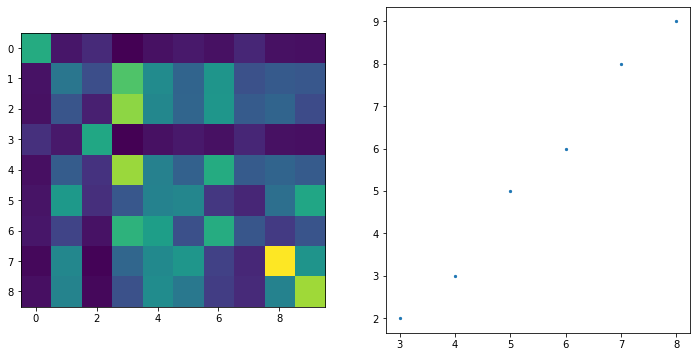

In [35]:
pen = np.array([[min(len(x), len(y)) / max(len(x), len(y)) for x in sents_er] for y in sents_ru])
sims = np.maximum(0, np.dot(emb_ru, emb_er.T)) ** 1 * pen

alpha = 0.2
penalty = 0.2
sims_rel = (sims.T - get_top_mean_by_row(sims) * alpha).T - get_top_mean_by_row(sims.T) * alpha - penalty

alignment = align3(sims_rel)

print(sum(sims[i, j] for i, j in alignment) / min(sims.shape))
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(sims_rel)
plt.subplot(1, 2, 2)
plt.scatter(*list(zip(*alignment)), s=5);

общий: 10% - плохо, 32% - хорошо

частный: 39% плохо, 59% хорошо

In [36]:
for i, j in alignment:
    print(sents_ru[i])
    print(sents_er[j])
    print(sims[i, j])
    print('-')

А я всё в спор — ну что за прелесть в этом?
Пелькстынь мартот — мень мазычи сёксесэнть?
0.3390202522277832
-
Люби и ты, как все, весну и лето.
Тундонть, кизэнть вечкема, кода весе.
0.6607618041940637
-
Дни эти (невдомёк мне было тоже) С тобою, дорогая, так похожи: Своё добро всем дарят, не жалея.
Сынь мартот ламосо вейкеть: Эсь ули-парост явшить апак жаля.
0.33342809426157094
-
Есть сердце матери в поре осенней.
Сёксесэнть — авань седей.
0.4611295812270221
-
Не пожалеет сил, тепла, вниманья, Хоть не всегда встречает пониманье.
Виензэ ды лембензэ сон а вансты, Куш аволь свал чарькодий вановт васты.
0.7470487414951056
-
Такую участь Бог посеял, видно, В твой День рожденья в поле твоей жизни.
Истямо чансть, авай, нать, Пазось видсь теть Эрямонь паксязот чачома чистэть.
0.6368352840473125
-


In [37]:
rus4all_pairs = []

In [38]:
tq = tqdm(pairs)
for pair in tq:
    sents_er = make_sents(pair['myv'])
    sents_ru = make_sents(pair['ru'])
    
    emb_ru = np.stack([embed(s) for s in sents_ru])
    emb_er = np.stack([embed(s) for s in sents_er])
    
    pen = np.array([[min(len(x), len(y)) / max(len(x), len(y)) for x in sents_er] for y in sents_ru])
    sims = np.maximum(0, np.dot(emb_ru, emb_er.T)) ** 1 * pen

    alpha = 0.2
    penalty = 0.2
    sims_rel = (sims.T - get_top_mean_by_row(sims) * alpha).T - get_top_mean_by_row(sims.T) * alpha - penalty

    alignment = align3(sims_rel)

    total_score = sum(sims[i, j] for i, j in alignment) / min(sims.shape)
    if total_score < 0.15:
        continue
    
    for i, j in alignment:
        if sims[i, j] >= 0.40: # порог высоковат; часть предложений мы потеряем, но полученные зато будут чистыми
            rus4all_pairs.append([sents_er[j], sents_ru[i]])
    tq.set_description(str(len(rus4all_pairs)))

  0%|          | 0/30 [00:00<?, ?it/s]

In [46]:
for p in rus4all_pairs:
    p[0] = p[0].replace('\xa0', ' ')
    p[1] = p[1].replace('\xa0', ' ')

In [59]:
random.choice(rus4all_pairs)

['— А бути чалгаса? — жигардома вайгельсэ мерсь Михалыч, буто Юрка бажась нельгемс олячинь праванзо, ды сон арсесь аштемс кисэст.',
 '— А ежели ступлю? — с вызовом спросил Михалыч, точно перед Юркой собирался свои права отстаивать.']

In [61]:
with open('other_sources/rus4all_myv_ru_aligned.json', 'w') as f:
    json.dump(rus4all_pairs, f, ensure_ascii=False)